<a href="https://colab.research.google.com/github/pathilink/sp_global_bootcamp/blob/main/5_desafio_teste_hipotese/desafio_teste_hipotese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio Teste de Hipóteses

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import shapiro # teste normalidade
from scipy.stats import levene  # teste variância homogênea
from scipy.stats import kruskal # teste significância
from scipy.stats import pearsonr, spearmanr # correlação

## Dados

| Variável | Descrição |
| :- | :- |
| id_produto | Código identificador do suplemento (Fórmula 1, 2 ou 3). |
| id_atleta | Código identificador do atleta que participou do estudo.|
| ganho_massa | Quantidade de massa muscular ganha (em kg) após 8 semanas de uso. |
| idade | Idade do atleta. |
| frequencia_treino | Número médio de treinos semanais do atleta. |

In [2]:
df = pd.read_csv('/content/drive/MyDrive/WoMakersCode/Bootcamp S&P Global/Teste de Hipótese/desafio_03_suplementos.csv')
df.head()

,id_produto,id_atleta,ganho_massa,idade,frequencia_treino
0,Fórmula 3,1,2.24,27,5
1,Fórmula 1,2,4.97,35,4
2,Fórmula 3,3,0.88,30,6
3,Fórmula 3,4,0.09,22,6
4,Fórmula 1,5,2.47,18,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_produto         300 non-null    object 
 1   id_atleta          300 non-null    int64  
 2   ganho_massa        300 non-null    float64
 3   idade              300 non-null    int64  
 4   frequencia_treino  300 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 11.8+ KB


In [4]:
print(f'Há {df.shape[0]} linhas e {df.shape[1]} colunas.')

Há 300 linhas e 5 colunas.


In [5]:
df.describe()

,id_atleta,ganho_massa,idade,frequencia_treino
count,300.000000,300.000000,300.000000,300.000000
mean,150.500000,2.466733,28.123333,3.993333
std,86.746758,1.436384,6.493742,1.430657
min,1.000000,0.030000,18.000000,2.000000
25%,75.750000,1.267500,22.000000,3.000000
50%,150.500000,2.400000,28.000000,4.000000
75%,225.250000,3.612500,34.000000,5.000000
max,300.000000,4.980000,39.000000,6.000000


In [6]:
# id's por produto
df.groupby('id_produto')['id_produto'].count().reset_index(name='total')

,id_produto,total
0,Fórmula 1,99
1,Fórmula 2,94
2,Fórmula 3,107


## Questões

### 1.
Faça uma análise exploratória dos dados:

* Qual é a média e a mediana do ganho de massa para cada suplemento?


In [7]:
df.groupby('id_produto')['ganho_massa'].agg(['mean', 'median']).rename(columns={'mean': 'média', 'median': 'mediana'})


,média,mediana
id_produto,,
Fórmula 1,2.656566,2.67
Fórmula 2,2.350106,2.15
Fórmula 3,2.393551,2.35


* Como os dados estão distribuídos? Utilize histogramas e boxplots para visualizar as diferenças entre as fórmulas.

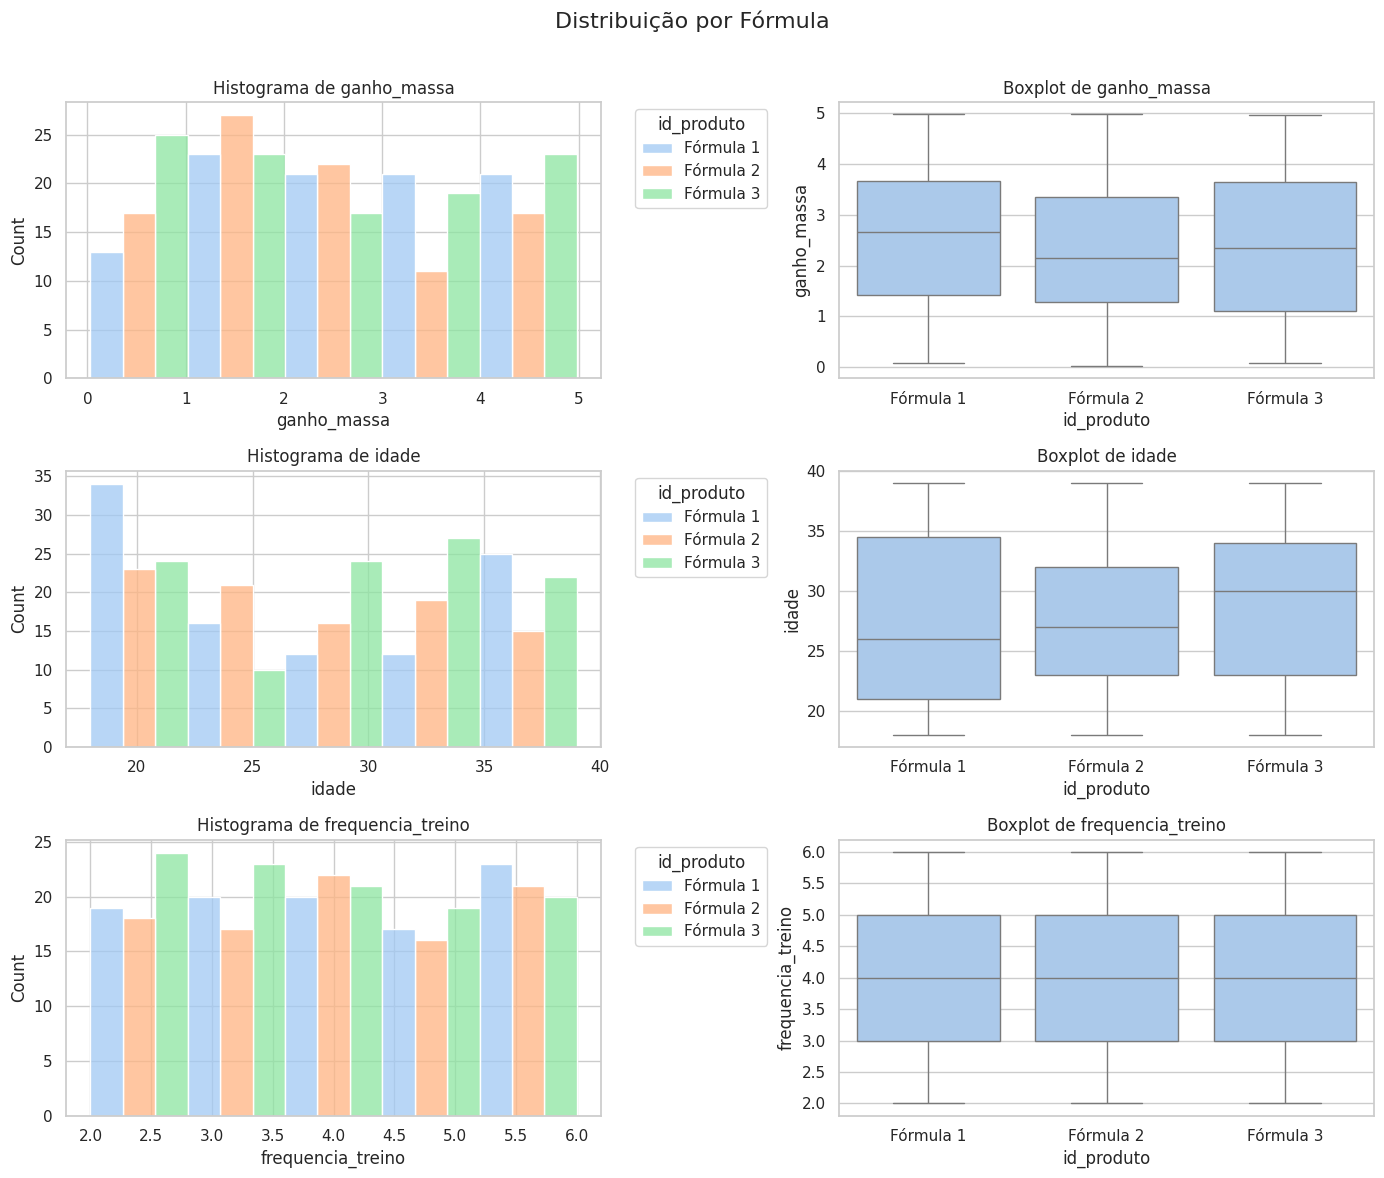

In [8]:
df_ = df.copy()
ordem = ['Fórmula 1', 'Fórmula 2', 'Fórmula 3']
df_['id_produto'] = pd.Categorical(df_['id_produto'], categories=ordem, ordered=True)

# Estilo dos gráficos
sns.set(style="whitegrid", palette="pastel")

# Cria uma figura com subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribuição por Fórmula', fontsize=16)

# Variáveis de interesse
variaveis = ['ganho_massa', 'idade', 'frequencia_treino']

# Loop para gerar histogramas e boxplots
for i, var in enumerate(variaveis):
    sns.histplot(data=df_, x=var, hue='id_produto', multiple='dodge', ax=axes[i, 0], bins=5)
    axes[i, 0].set_title(f'Histograma de {var}')
    axes[i, 0].legend_.set_bbox_to_anchor((1.05, 1))  # <- legenda fora

    sns.boxplot(data=df_, x='id_produto', y=var, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {var}')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

* Há outliers no ganho de massa muscular? O que isso pode indicar?

<font color=blue>O boxplot do ganho de massa muscular não apresenta outliers. Isso pode indicar que os atletas apresentam características semelhantes e comparáveis. Além disso, pode indicar pouca possibilidade de haver alguma variável espúria relacionada aos atletas.</font>

### 2.
Há diferença estatisticamente significativa no ganho de massa muscular entre as três fórmulas?

<font color=blue>Para escolher o teste de significância a ser aplicado é necessário testar a normalidade e/ou verificar a diferença ou não entre as variâncias.
<li>Se os dados forem normais e variâncias homogêneas: ANOVA</li>
<li>Se não forem normais ou variâncias forem diferentes: Teste de Kruskal-Wallis</li>

Se não forem normais ou variâncias forem diferentes: Teste de Kruskal-Wallis</font>


| Situação |	Teste recomendado |
| :- | :- |
| Normal + variâncias iguais	| ANOVA |
| Algum grupo não normal |	Kruskal-Wallis |
| Variâncias diferentes	| Kruskal-Wallis |

In [9]:
# Teste de normalidade por grupo
for grupo, dados in df.groupby('id_produto'):
    stat, p = shapiro(dados['ganho_massa'])
    print(f'{grupo}: stat={stat:.3f}, p={p:.4f}')
    if p < 0.05:
        print("  ❌ Não é normal")
    else:
        print("  ✅ É normal")


Fórmula 1: stat=0.959, p=0.0036
  ❌ Não é normal
Fórmula 2: stat=0.952, p=0.0018
  ❌ Não é normal
Fórmula 3: stat=0.942, p=0.0002
  ❌ Não é normal


In [10]:
# Divide os grupos
grupos = [grupo['ganho_massa'].values for _, grupo in df.groupby('id_produto')]

# Teste de Levene
stat, p = levene(*grupos)
print(f'Teste de Levene: stat={stat:.3f}, p={p:.4f}')
if p < 0.05:
    print("  ❌ Variâncias diferentes (heterocedasticidade)")
else:
    print("  ✅ Variâncias homogêneas")


Teste de Levene: stat=1.291, p=0.2765
  ✅ Variâncias homogêneas


<font color=blue>
Hipótese nula: "Não há diferença estatisticamente significativa entre os grupos."<br>
<li>H0: p = 0</li>
Hipótese alternativa: "Há diferença estatisticamente significativa entre os grupos."
<li>H1: p != 0</li>
<br>
Como os grupos não apresentam distribuição normal, optou-se pelo teste de Kruskal-Wallis.
</font>


In [11]:
# Teste de Kruskal-Wallis
grupos = [grupo['ganho_massa'].values for nome, grupo in df_.groupby('id_produto', observed=False)]
stat, p_valor = kruskal(*grupos)

print(f'Estatística H = {stat:.2f}')
print(f'Valor-p = {p_valor:.4f}')

if p_valor < 0.05:
    print("➡️ Há diferença estatisticamente significativa entre os grupos.")
else:
    print("➡️ Não há diferença estatisticamente significativa entre os grupos.")

Estatística H = 2.65
Valor-p = 0.2662
➡️ Não há diferença estatisticamente significativa entre os grupos.


### 3.
Existe correlação entre idade e ganho de massa muscular? Atletas mais jovens ou mais velhos têm resultados diferentes?

<font color=blue>
Scatterplot ajuda a ver a tendência geral.
<li>A Fórmula 2 apresenta maior ganho de massa muscular em idades mais jovens.</li>
<li>As Fórmulas 1 e 3 apresentam leve variação entre as idades.</li>
</font>

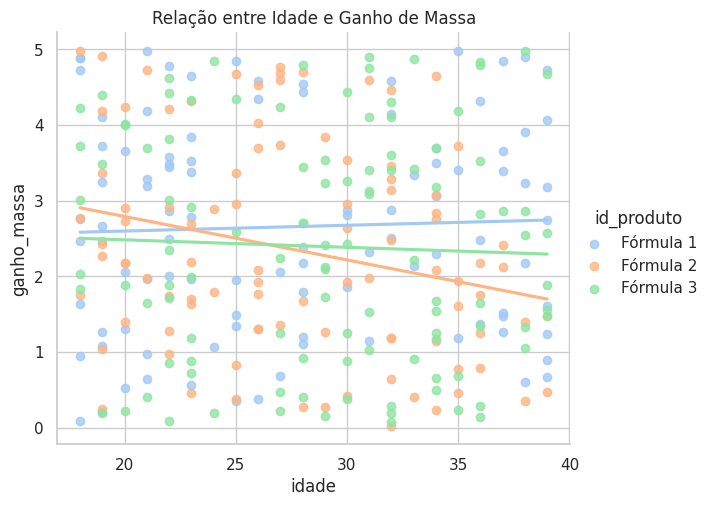

In [12]:
sns.lmplot(data=df_, x='idade', y='ganho_massa', hue='id_produto', ci=None, height=5, aspect=1.2)
plt.title('Relação entre Idade e Ganho de Massa')
plt.show()

<font color=blue>
Hipótese nula: "Não existe correlação entre idade e ganho de massa muscular"<br>
<li>H0: p = 0</li>
Hipótese alternativa: "Existe correlação entre idade e ganho de massa muscular"
<li>H1: p != 0</li>
<br>
Possíveis interpretações:
<li>rho positivo → quanto maior a idade, maior o ganho</li>
<li>rho negativo → quanto maior a idade, menor o ganho</li>
<li>Valor-p < 0.05 → correlação significativa</li>
<li>Valor de correlação perto de 0 → correlação fraca ou inexistente</li>
<br>
Os dados apresentaram correlação de -0.08, ou seja, entre todas as fórmulas quanto maior a idade, menor é o ganho de massa muscular.
<br><br>
O valor-p de 0.1847 indica que a correlação não é estatisticamente significativa ao nível de significância padrão (α = 0.05). Ou seja:
<li>p = 0.1847 > 0.05 → Não rejeitamos a hipótese nula (H0)</li>
<br>
Portanto, não temos evidências suficientes para afirmar que idade influencia o ganho de massa muscular neste conjunto de dados.
</font>

In [13]:
# Correlação de Spearman (dados não normais)
spearman_corr, p_spearman = spearmanr(df_['idade'], df_['ganho_massa'])
print(f'Correlação de Spearman: rho = {spearman_corr:.2f}, p = {p_spearman:.4f}')

Correlação de Spearman: rho = -0.08, p = 0.1847


### 4.
Atletas que treinam mais frequentemente ganham mais massa muscular independentemente do suplemento?

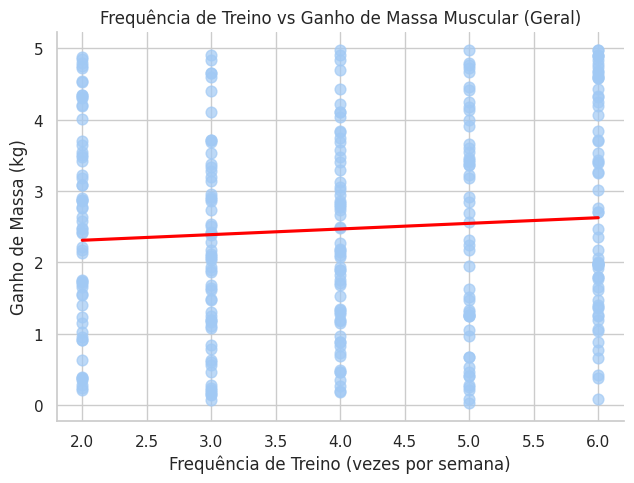

In [14]:
sns.lmplot(
    data=df_,
    x='frequencia_treino',
    y='ganho_massa',
    ci=None,          # sem intervalo de confiança
    height=5,
    aspect=1.3,
    scatter_kws={'s': 60, 'alpha': 0.7},  # bolinhas maiores e transparentes
    line_kws={'color': 'red'}             # linha vermelha
)

plt.title('Frequência de Treino vs Ganho de Massa Muscular (Geral)')
plt.xlabel('Frequência de Treino (vezes por semana)')
plt.ylabel('Ganho de Massa (kg)')
plt.tight_layout()
plt.show()


<font color=blue>
Graficamente, a relação entre frequência de treino e ganho de massa muscular, sem separar por suplemento, apresenta tendência de alta. Ou seja, quanto maior a quantidade de treinos, maior é o ganho de massa muscular.
</font>

In [15]:
# Correlação de Spearman entre frequência e ganho de massa (sem separar por fórmula)
corr_spearman, p_valor_spearman = spearmanr(df_['frequencia_treino'], df_['ganho_massa'])

print(f'Correlação de Spearman: ρ = {corr_spearman:.2f}')
print(f'Valor-p = {p_valor_spearman:.4f}')
if p_valor_spearman < 0.05:
    print("➡️ Correlação significativa entre frequência de treino e ganho de massa.")
else:
    print("➡️ Sem evidência de correlação significativa entre frequência e ganho.")


Correlação de Spearman: ρ = 0.07
Valor-p = 0.2033
➡️ Sem evidência de correlação significativa entre frequência e ganho.


<font color=blue>
Hipótese nula: "Não existe correlação entre frequência e ganho de massa muscular"<br>
<li>H0: p = 0</li>
Hipótese alternativa: "Existe correlação entre frequência e ganho de massa muscular"
<li>H1: p != 0</li>
<br>
Possíveis interpretações:
<li>ρ positivo: à medida que a frequência aumenta, o ganho tende a aumentar.</li>
<li>ρ negativo: mais treino → menos ganho.</li>
<li>p < 0.05: correlação estatisticamente significativa.</li>
<br>
Aplicando a correlação de Spearman (os dados não são normalmente distribuídos), não há evidência de correlação significativa entre frequência e ganho de massa muscular. Portanto, não se rejeita H0.
</font>

### 5.
Existe alguma correlação entre idade, frequência de treino e a eficácia do suplemento?

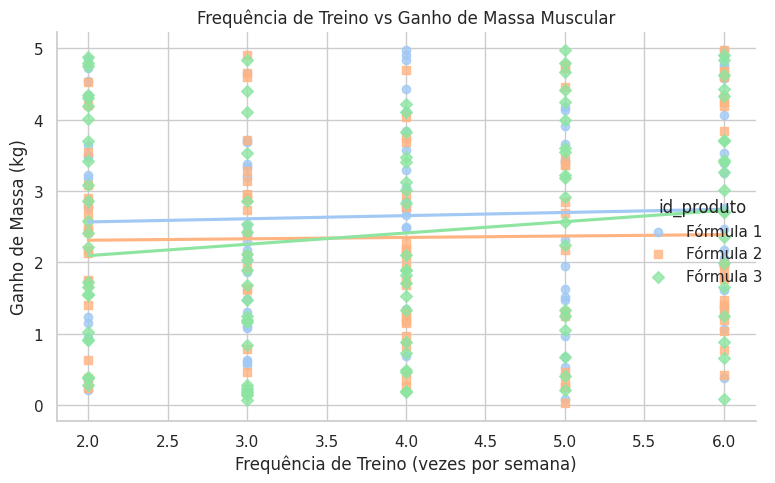

In [16]:
# linha de regressão por suplemento
sns.lmplot(
    data=df_,
    x='frequencia_treino',
    y='ganho_massa',
    hue='id_produto',
    ci=None,            # sem intervalo de confiança
    height=5,
    aspect=1.3,
    markers=['o', 's', 'D']
)

plt.title('Frequência de Treino vs Ganho de Massa Muscular')
plt.xlabel('Frequência de Treino (vezes por semana)')
plt.ylabel('Ganho de Massa (kg)')
plt.tight_layout()
plt.show()

<font color=blue>
Graficamente, a relação entre frequência de treino e ganho de massa muscular separando por suplemento:
<li>Fórmula 3 apresenta tendência de alta. Ou seja, quanto maior a quantidade de treinos, maior é o ganho de massa muscular.</li>
<li>Fórmulas 1 e 2 apresentaram pouca variação no ganho de massa conforme aumenta-se a frequência de treinos.</li>
</font>

In [17]:
# Lista única das fórmulas
formulas = df['id_produto'].unique()

# Loop por fórmula
for f in sorted(formulas, key=lambda x: int(x.split()[-1])):  # ordena como 1, 2, 3
    dados = df_[df_['id_produto'] == f]
    rho, p = spearmanr(dados['frequencia_treino'], dados['ganho_massa'])
    print(f"Fórmula {f} ➜ Spearman ρ = {rho:.2f} | p = {p:.4f}")
    if p < 0.05:
        print("   ↳ Correlação significativa.")
    else:
        print("   ↳ Correlação não significativa.")


Fórmula Fórmula 1 ➜ Spearman ρ = 0.05 | p = 0.6418
   ↳ Correlação não significativa.
Fórmula Fórmula 2 ➜ Spearman ρ = -0.02 | p = 0.8701
   ↳ Correlação não significativa.
Fórmula Fórmula 3 ➜ Spearman ρ = 0.14 | p = 0.1456
   ↳ Correlação não significativa.


<font color=blue>
Hipótese nula: "Não existe correlação entre frequência e ganho de massa muscular"<br>
<li>H0: p = 0</li>
Hipótese alternativa: "Existe correlação entre frequência e ganho de massa muscular"
<li>H1: p != 0</li>
<br>
Portanto, nenhuma das fórmulas apresentaram correlação significativa entre frequência e ganho de massa, portanto, não se rejeita H0.
</font>


### 6.
Qual fórmula você recomendaria para atletas que treinam mais de 5 vezes por semana? Justifique sua escolha.

In [18]:
df_freq = df_.query('frequencia_treino > 5').copy()
df_freq.sample(5)

,id_produto,id_atleta,ganho_massa,idade,frequencia_treino
275,Fórmula 1,276,4.58,26,6
221,Fórmula 3,222,4.33,23,6
290,Fórmula 2,291,1.40,20,6
57,Fórmula 1,58,2.76,18,6
186,Fórmula 3,187,3.40,32,6


In [19]:
df_freq[['ganho_massa',	'idade', 'frequencia_treino']].describe()

,ganho_massa,idade,frequencia_treino
count,64.000000,64.00000,64.0
mean,2.829687,26.78125,6.0
std,1.471458,6.37323,0.0
min,0.090000,18.00000,6.0
25%,1.640000,22.00000,6.0
50%,2.705000,26.00000,6.0
75%,4.322500,31.00000,6.0
max,4.980000,39.00000,6.0


In [20]:
media = df_freq.groupby('id_produto', observed=False)['ganho_massa'].mean().sort_index()
mediana = df_freq.groupby('id_produto', observed=False)['ganho_massa'].median().sort_index()

print("📊 Ganho de Massa entre atletas que treinam mais de 5x por semana:")
print("\nMédia por fórmula:\n", media)
print("\nMediana por fórmula:\n", mediana)

📊 Ganho de Massa entre atletas que treinam mais de 5x por semana:

Média por fórmula:
 id_produto
Fórmula 1    3.012609
Fórmula 2    2.566190
Fórmula 3    2.896000
Name: ganho_massa, dtype: float64

Mediana por fórmula:
 id_produto
Fórmula 1    2.760
Fórmula 2    1.920
Fórmula 3    3.135
Name: ganho_massa, dtype: float64


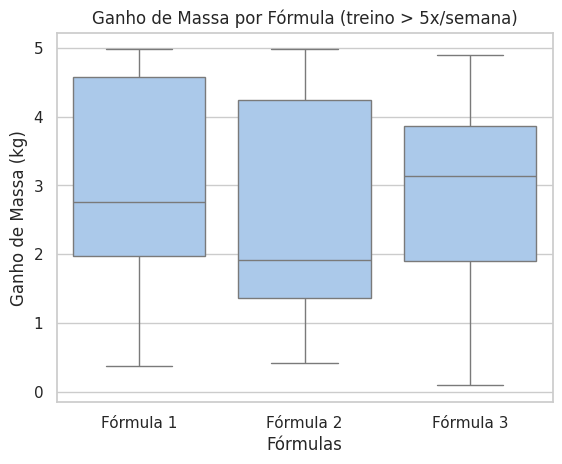

In [21]:
sns.boxplot(data=df_freq, x='id_produto', y='ganho_massa')
plt.title('Ganho de Massa por Fórmula (treino > 5x/semana)')
plt.xlabel('Fórmulas')
plt.ylabel('Ganho de Massa (kg)')
plt.show()


<font color=blue>As fórmulas 1 e 3 possuem o maior valor mínimo no ganho de massa. Além disso, a fórmula 1 possui o maior valor máximo. Portanto, a fórmula 1 seria recomendada por apresentar a maior possibilidade de ganho de massa muscular. Apesar da mediana da fórmula 1 ser menor do que da fórmula 3 por conta da maior dispersão dos dados.
</font>